# Compute Kernel for CellRank 

**RNA velocity** [Bergen et al., 2021](https://www.embopress.org/doi/full/10.15252/msb.202110282)  
Beyond the scope of computational modeling, the statistical power of the methods depends on the curvature in the phase portrait since a lack of curvature challenges current models to distinguish whether an up- or down-regulation is occurring. The overall curvature of deviation from the steady-state line in the phase portrait is mostly impacted by the ratios of splicing to degradation rates (Box 1), **indicating that statistical inference is limited to genes where splicing is faster or comparable to degradation, while a small ratio would yield straight lines rather than an interpretable curvature.**  

**MURK genes** [GitHub](https://github.com/mebarile/Gata1_Erythroid_kinetics/blob/main/Figure_6/search_and_rank_murk_human.ipynb)

In [1]:
import scanpy as sc
import scanpy.external as sce
import scvelo as scv

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as mpl

import os
import sys

import warnings

## Root directory

In [2]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

## Custom modules

In [3]:
sys.path.append('bin/')
from adata_qc import *

## Settup rpy2 

In [4]:
os.environ['R_HOME'] = '/nobackup/peer/fdeckert/miniconda3/envs/r.4.4.1-FD20200109SPLENO/lib/R'

In [5]:
import rpy2
%load_ext rpy2.ipython

## Figures 

In [6]:
sc.set_figure_params(figsize=(5, 5), dpi_save=1200, fontsize=12, frameon=False, facecolor='white')
mpl.rcParams['figure.facecolor'] = 'white'

# Import data 

In [7]:
adata = sc.read_h5ad('data/scRNAseq/object/pp.h5ad')
adata_v = sc.read_h5ad('data/scRNAseq/object/velocyto.h5ad')

# Transfer velocyto matrices 

In [8]:
obs_names = adata.obs_names
var_names = adata.var_names.intersection(adata_v.var_names)

In [9]:
adata = adata[obs_names, var_names]
adata_v = adata_v[obs_names, var_names]

In [10]:
adata.X = adata_v.X
adata.layers = adata_v.layers

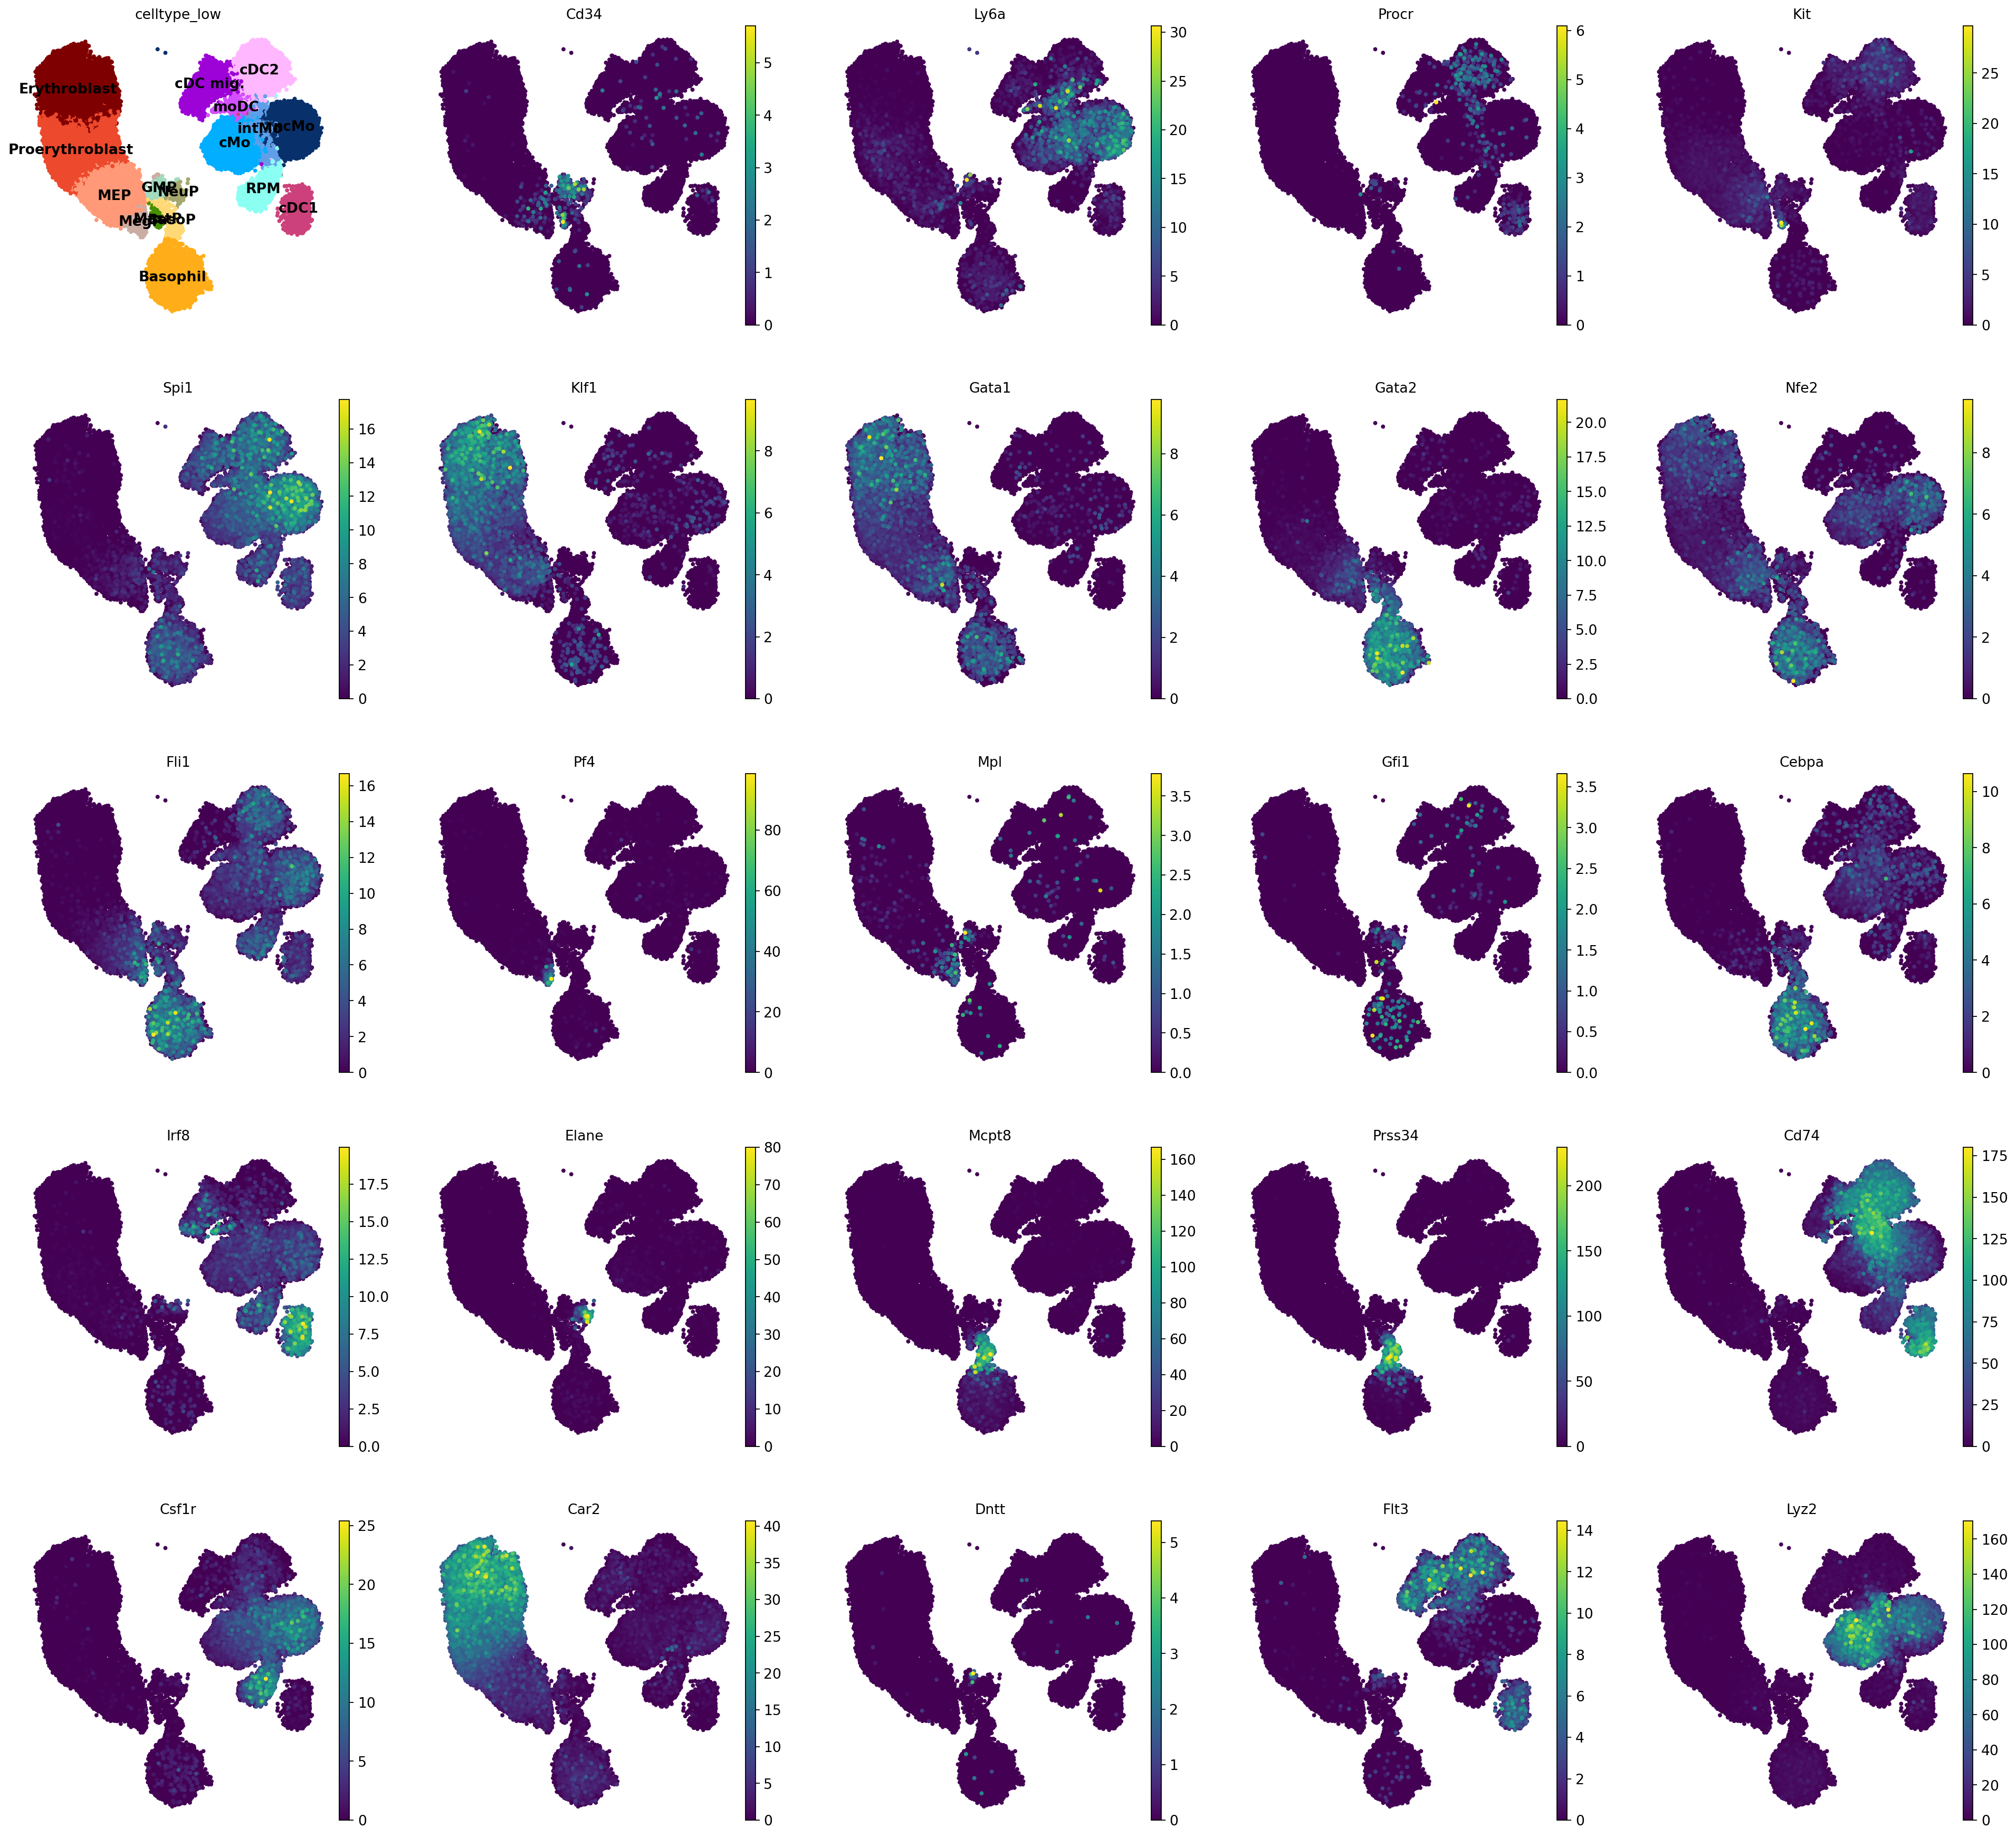

In [11]:
# UMAP 
sc.pl.umap(sc.pp.normalize_total(adata.raw.to_adata(), copy=True), color=['celltype_low', 'Cd34', 'Ly6a', 'Procr', 'Kit', 'Spi1', 'Klf1', 'Gata1', 'Gata2', 'Nfe2', 'Fli1', 'Pf4', 'Mpl', 'Gfi1', 'Cebpa', 'Irf8', 'Elane', 'Mcpt8', 'Prss34', 'Cd74', 'Csf1r', 'Car2', 'Dntt', 'Flt3', 'Lyz2'], legend_loc='on data', ncols=5, size=50, use_raw=False)

# Store full matrix 

In [12]:
adata_tmp = adata.copy()

# Helper function

In [13]:
###########
### PCA ###
###########
def pca_workflow(adata, n_comps): 
    
    adata = adata.raw.to_adata()
    
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=False)
    
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    sc.pp.pca(adata, n_comps=n_comps, use_highly_variable=True)
    
    X_pca = adata.obsm['X_pca']
    
    return(X_pca)

In [14]:
#######################
### Velocity kernel ###
#######################
def vk_workflow(adata, suffix, compute=False):
    
    if compute: 
        
        # Set genes to include for moment computation 
        adata.var['m_genes'] = adata.var.index.isin(scv.pp.filter_and_normalize(adata, min_shared_counts=20, subset_highly_variable=False, n_top_genes=None, log=False, copy=True).var_names)
        
        # Compute PCA 
        adata.obsm['X_pca'] = pca_workflow(adata.copy(), n_comps=30)
        
        # Compute neighbors on PCA 
        sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep='X_pca')
        
        # Normalize X, spliced, and unspliced
        sc.pp.normalize_total(adata, layers=['spliced', 'unspliced'], target_sum=1e6)
        sc.pp.log1p(adata)

        # Subset by var names filter
        adata = adata[:, adata.var['m_genes']].copy()

        # First-/second-order moments are computed for each cell across its nearest neighbors
        scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
        scv.tl.recover_dynamics(adata)

        # Estimates velocities in a gene-specific manner
        scv.tl.velocity(adata, mode='dynamical')
            
        # Get velocity and top likelihood fit genes 
        v_df = adata.var
        v_df = v_df[v_df.velocity_genes]
        v_df = v_df[v_df.fit_likelihood>=0.1]
            
        v_genes = v_df.index
            
        # Velocity graph (re-compute)
        scv.tl.velocity_graph(adata, gene_subset=v_genes)

        # Velocity pseudotime 
        scv.tl.velocity_pseudotime(adata)
            
        # Terminal and root cells 
        scv.tl.recover_latent_time(adata)
            
        # Fit differential kinetics on velocity genes
        # scv.tl.differential_kinetic_test(adata, var_names=adata.var_names[adata.var.velocity_genes], groupby='celltype_low')

        # CellRank kernel 
        from cellrank.kernels import VelocityKernel
        vk = VelocityKernel(adata)
        
        vk.write('data/scRNAseq/object/cellrank/kernel/vk'+suffix+'.pickle', write_adata=True)
        
    else: 
        
        from cellrank.kernels import VelocityKernel
        vk = VelocityKernel.read(fname='data/scRNAseq/object/cellrank/kernel/vk'+suffix+'.pickle')
        
    return vk

In [15]:
#######################
### Palantir kernel ###
#######################
def pk_workflow(adata, suffix, s_genes, t_genes, compute=False):
    
    if compute:
        
        # Use the full matrix instead of velocity matrix 
        adata = adata.raw.to_adata()
        adata.raw = adata.copy()
        
        # Compute PCA 
        adata.obsm['X_pca'] = pca_workflow(adata.copy(), n_comps=300)
        
        # Compute neighbors on PCA 
        sc.pp.neighbors(adata, n_neighbors=30, n_pcs=300, use_rep='X_pca')
        
        # Palantir diffusion maps based on PCA
        sce.tl.palantir(adata, n_components=10, knn=30)

        # Normalize for module score computation 
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)

        # Compute starting cell
        for k, v in s_genes.items():
            sc.tl.score_genes(adata, v, score_name='t_score_'+ k.lower(), use_raw=False)
            t_cell=adata.obs['t_score_'+ k.lower()].idxmax()
            s_genes[k] = t_cell
        s_id = pd.Series(list(s_genes.keys()), list(s_genes.values()))

        # Compute terminal state cells
        for k, v in t_genes.items():
            sc.tl.score_genes(adata, v, score_name='t_score_'+ k.lower(), use_raw=False)
            t_cell=adata.obs['t_score_'+ k.lower()].idxmax()
            t_genes[k] = t_cell
        t_id = pd.Series(list(t_genes.keys()), list(t_genes.values()))

        adata.obs = adata.obs.join(pd.DataFrame({'pt_cells':pd.concat([s_id, t_id]).tolist()}, index=pd.concat([s_id, t_id]).index), how='left')
        adata.obs['pt_cells'] = adata.obs['pt_cells'].astype('category')

        # Set back raw data  
        adata = adata.raw.to_adata()
        adata.raw = adata.copy()
        
        # Palantir results 
        pr_res = sce.tl.palantir_results(
            adata,
            early_cell=s_id.index[0], 
            terminal_states=t_id, 
            ms_data='X_palantir_multiscale',
            num_waypoints=500, 
            use_early_cell_as_start=True
        )
        
        # Get pseudotime 
        adata.obs['ppt_pseudotime'] = pr_res.pseudotime
        
        # Use original data
        adata = adata.raw.to_adata()
        adata.raw = adata.copy()
        

        # CellRank kernel 
        from cellrank.kernels import PseudotimeKernel
        pk = PseudotimeKernel(adata, time_key='ppt_pseudotime')

        pk.write('data/scRNAseq/object/cellrank/kernel/pk'+suffix+'.pickle', write_adata=True)
    
    else: 
        
        from cellrank.kernels import PseudotimeKernel
        pk = PseudotimeKernel.read(fname='data/scRNAseq/object/cellrank/kernel/pk'+suffix+'.pickle')
    
    return pk

In [16]:
###########################
### Connectivity kernel ###
###########################
def ck_workflow(adata, suffix, compute=False):
    
    if compute: 
        
        # Neighbor graph on latent space 
        sc.pp.neighbors(adata, n_neighbors=30, n_pcs=None, use_rep='latent')
        
        # CellRank kernel 
        from cellrank.kernels import ConnectivityKernel
        ck = ConnectivityKernel(adata)
        
        ck.write('data/scRNAseq/object/cellrank/kernel/ck'+suffix+'.pickle', write_adata=True)
        
    else: 
        
        from cellrank.kernels import ConnectivityKernel
        ck = ConnectivityKernel.read(fname='data/scRNAseq/object/cellrank/kernel/ck'+suffix+'.pickle')
        
    return ck

# Kernel Erythroid

In [ ]:
celltype_ery = [

    'MegP', 
    'MEP',
    'Proerythroblast', 
    'Erythroblast'
    
]

In [ ]:
# Subset by Erythroid cluster 
adata = adata_tmp[adata_tmp.obs.celltype_low.isin(celltype_ery)].copy()

## Kernel Erythroid (WT Ctl) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_ery)).values & (adata_i.obs.sample_group=='Bl6_NaCl_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_ery_wt_ctl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_ery_wt_ctl', compute=False, s_genes=dict(Start=['Slamf1']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_ery_wt_ctl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=50, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_meg', 't_score_ery'], legend_loc='on data', ncols=6, size=50)

## Kernel Erythroid (WT D6) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_ery)).values & (adata_i.obs.sample_group=='Bl6_CpG_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_ery_wt_d6', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_ery_wt_d6', compute=False, s_genes=dict(Start=['Slamf1']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_ery_wt_d6', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_meg', 't_score_ery'], legend_loc='on data', ncols=10, size=100)

## Kernel Erythroid (IFNAR fl/fl) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_ery)).values & (adata_i.obs.genotype=='IFNAR_fl').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl', compute=False, s_genes=dict(Start=['Slamf1']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_meg', 't_score_ery'], legend_loc='on data', ncols=10, size=100)

## Kernel Erythroid (IFNAR fl/fl LyzM Cre) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_ery)).values & (adata_i.obs.genotype=='IFNAR_fl_LysM_cre').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl_lysm_cre', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl_lysm_cre', compute=False, s_genes=dict(Start=['Slamf1']), t_genes=dict(Ery=['Hbb-bt'], Meg=['Pf4']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_ery_ifnar_fl_lysm_cre', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_meg', 't_score_ery'], legend_loc='on data', ncols=10, size=100)

# Kernel Myeloid

In [ ]:
celltype_m = [

    'cMo', 
    'moDc', 
    'intMo',
    'ncMo', 
    'RPM'
    
]

In [ ]:
# Subset by Erythroid cluster 
adata = adata_tmp[adata_tmp.obs.celltype_low.isin(celltype_m)].copy()

## Kernel Myeloid (WT Ctl) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_m)).values & (adata_i.obs.sample_group=='Bl6_NaCl_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_m_wt_ctl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_m_wt_ctl', compute=False, s_genes=dict(Start=['Ly6c2', 'Ccr2']), t_genes=dict(ncMo=['Cx3cr1', 'Nr4a1'], RPM=['Cd163'], moDC=['Flt3']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_m_wt_ctl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=50, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ncmo', 't_score_rpm', 't_score_modc'], legend_loc='on data', ncols=7, size=50)

## Kernel Myeloid (WT D6) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_m)).values & (adata_i.obs.sample_group=='Bl6_CpG_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_m_wt_d6', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_m_wt_d6', compute=False, s_genes=dict(Start=['Ly6c2', 'Ccr2']), t_genes=dict(ncMo=['Cx3cr1', 'Nr4a1'], RPM=['Cd163'], moDC=['Flt3']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_m_wt_d6', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ncmo', 't_score_rpm', 't_score_modc'], legend_loc='on data', ncols=7, size=50)

## Kernel Myeloid (IFNAR fl/fl) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_m)).values & (adata_i.obs.genotype=='IFNAR_fl').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl', compute=False, s_genes=dict(Start=['Ly6c2', 'Ccr2']), t_genes=dict(ncMo=['Cx3cr1', 'Nr4a1'], RPM=['Cd163'], moDC=['Flt3']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ncmo', 't_score_rpm', 't_score_modc'], legend_loc='on data', ncols=7, size=50)

## Kernel Myeloid (IFNAR fl/fl LyzM Cre) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_m)).values & (adata_i.obs.genotype=='IFNAR_fl_LysM_cre').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl_lysm_cre', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl_lysm_cre', compute=False, s_genes=dict(Start=['Ly6c2', 'Ccr2']), t_genes=dict(ncMo=['Cx3cr1', 'Nr4a1'], RPM=['Cd163'], moDC=['Flt3']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_m_ifnar_fl_lysm_cre', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_ncmo', 't_score_rpm', 't_score_modc'], legend_loc='on data', ncols=7, size=50)

# Kernel Progenitor 

In [17]:
celltype_p = [

    'GMP', 
    'NeuP', 
    'BasoP', 
    'MastP', 
    'MegP',
    'MEP', 
    'Proerythroblast'
    
]

In [18]:
# Subset by Erythroid cluster 
adata = adata_tmp[adata_tmp.obs.celltype_low.isin(celltype_p)].copy()

## Kernel Progenitor (WT Baseline) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values & (adata_i.obs.sample_group=='Bl6_NaCl_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p_wt_ctl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p_wt_ctl', compute=False, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p_wt_ctl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)

## Kernel Progenitor (WT CpG D6) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values & (adata_i.obs.sample_group=='Bl6_CpG_D6').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p_wt_d6', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p_wt_d6', compute=False, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p_wt_d6', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)

## Kernel Progenitor (IFNAR fl/fl) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values & (adata_i.obs.genotype=='IFNAR_fl').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl', compute=False, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)

## Kernel Progenitor (IFNAR fl/fl LyzM Cre) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values & (adata_i.obs.genotype=='IFNAR_fl_LysM_cre').values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl_lysm_cre', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl_lysm_cre', compute=False, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p_ifnar_fl_lysm_cre', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)

## Kernel Progenitor (VBC) 

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values & (adata_i.obs.genotype.isin(['IFNAR_fl', 'IFNAR_fl_LysM_cre'])).values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p_vbc', compute=False)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p_vbc', compute=False, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p_vbc', compute=False)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)

## Kernel Progenitor

In [ ]:
adata_i = adata.copy()
adata_i = adata_i[(adata_i.obs.celltype_low.isin(celltype_p)).values].copy()

In [ ]:
vk_i = vk_workflow(adata=adata_i.copy(), suffix='_p', compute=True)
pk_i = pk_workflow(adata=adata_i.copy(), suffix='_p', compute=True, s_genes=dict(Start=['Hlf']), t_genes=dict(MEP=['Cd24a', 'Tfrc'], MegP=['Pf4'], MastP=['Cma1'], NeuP=['Elane'], BasoP=['Prss34']))
ck_i = ck_workflow(adata=adata_i.copy(), suffix='_p', compute=True)

In [ ]:
warnings.simplefilter("ignore")
sc.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)
scv.set_figure_params(figsize=(2.5, 5), dpi_save=1200, fontsize=10, color_map='magma', frameon=False)

In [ ]:
scv.pl.velocity_embedding_stream(vk_i.adata, basis='X_umap', color=['celltype_low', 'velocity_pseudotime', 'latent_time', 'root_cells', 'end_points', 'S_score_scale', 'G2M_score_scale'], legend_loc='on data', ncols=7, size=100, density=1.5, recompute=False)

In [ ]:
scv.pl.umap(pk_i.adata, color=['celltype_low', 'ppt_pseudotime', 'pt_cells', 't_score_start', 't_score_mep', 't_score_megp', 't_score_mastp', 't_score_neup', 't_score_basop'], legend_loc='on data', ncols=7, size=100)